In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
from sklearn.model_selection import GridSearchCV
import statistics as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.colors as mcolors

In [19]:
df = pd.read_csv('LoanReshaped_E.csv')
Status_col = df.iloc[:, 29]
df = df.drop(df.columns[29], axis=1)
df = pd.concat([Status_col, df], axis=1)

dfNoGender = df.drop(df.columns[2], axis=1)
dfNoDemo = dfNoGender.drop(df.columns[1], axis=1)

In [20]:
#Splitting the Data
from sklearn.model_selection import train_test_split, cross_val_score

X = df.iloc[:,1:]
y = df.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

XNG = dfNoGender.iloc[:,1:]
yNG = dfNoGender.iloc[:,0]
X_trainNG, X_testNG, y_trainNG, y_testNG = train_test_split(XNG, yNG, test_size=0.25, random_state=42, stratify=y)

XND = dfNoDemo.iloc[:,1:]
yND = dfNoDemo.iloc[:,0]
X_trainND, X_testND, y_trainND, y_testND = train_test_split(XND, yND, test_size=0.25, random_state=42, stratify=y)

XFemPred = dfNoDemo.iloc[:,1:]
yFemPred = df.iloc[:,2]
X_trainFP, X_testFP, y_trainFP, y_testFP = train_test_split(XFemPred, yFemPred, test_size=0.25, random_state=42, stratify=y)

XAgePred = dfNoDemo.iloc[:,1:]
yAgePred = df.iloc[:,1]
quartiles = np.quantile(yAgePred, [0, 0.33, 0.66, 1])
bin_edges = [quartiles[0], quartiles[1], quartiles[2], quartiles[3]]
bin_indices = np.digitize(yAgePred, bin_edges)
yAgePred = np.array([bin_indices[i] for i in range(len(yAgePred))])

X_trainAP, X_testAP, y_trainAP, y_testAP = train_test_split(XAgePred, yAgePred, test_size=0.25, random_state=42, stratify=y)

X_train.shape

(27048, 34)

0.6221803598134981
0.641840074842514
0.624631755005233
0.646581098606072
0.629852042158191
0.6460893152276072
0.6300978864542441
0.6440840611614813
0.6338860617736223
0.6430560756558935
[0.6221803598134981, 0.641840074842514, 0.624631755005233, 0.646581098606072, 0.629852042158191, 0.6460893152276072, 0.6300978864542441, 0.6440840611614813, 0.6338860617736223, 0.6430560756558935]


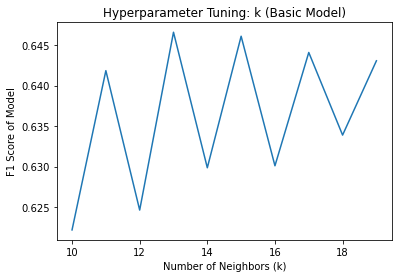

In [24]:
k_lst = []
f1_lst = []

for k in range(10,20):
    k_lst.append(k)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    scores = cross_val_score(knn, X_train[0:10000], y_train[0:10000], cv=5, scoring='f1_macro', error_score="raise")
    print(scores.mean())
    f1_lst.append(scores.mean())

plt.plot(k_lst, f1_lst)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('F1 Score of Model')
plt.title('Hyperparameter Tuning: k (Basic Model)')
plt.show
plt.savefig('tuning_k_basic.pdf', bbox_inches='tight')

print(f1_lst)

In [ ]:
from sklearn.svm import LinearSVC

def linear():
    model = LinearSVC()
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='f1_macro', error_score="raise")
    print('CV score:', scores.mean(), "+/-", scores.std())
    
linear()

In [23]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict

model = SVC(kernel='rbf')
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro', error_score="raise")
print('CV score:', scores.mean(), "+/-", scores.std())

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = f1_score(y_pred, y_test, average='macro')
print(score)

# 0.7653 F1_Score

CV score: 0.6010117479469974 +/- 0.0086914613143229
0.6111506505332347


In [8]:
#SGD Classifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
model = SGDClassifier(loss = 'log_loss')

scores = cross_val_score(model, X_train, y_train, cv=10, scoring='f1_macro', error_score="raise")
print(scores.mean())

/opt/pub/eb/apps/all/DavidsonJupyter/2021-common-GCCcore-10.2.0/lib/python3.8/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


0.09689997647428403


In [ ]:
#Random Forest Classifier


model = RandomForestClassifier()
# scores = cross_val_score(model, X_train, y_train, cv=10, scoring='f1_macro', error_score="raise")
# print('CV score:', scores.mean(), "+/-", scores.std())

param_grid = {
    'n_estimators': [600]
}

# create a GridSearchCV object with the specified hyperparameter grid
grids = GridSearchCV(model, param_grid, cv=5, scoring = ['f1_macro', 'precision', 'recall'], refit='f1_macro', verbose = 1)

# fit the grid search object to the data
grids.fit(X_train , y_train)

# print the best hyperparameters and the corresponding score
print("Best hyperparameters: ", grids.best_params_)
print("Best score: ", grids.best_score_)

0.8944125481763772


Text(83.40000000000006, 0.5, 'Actual Values')

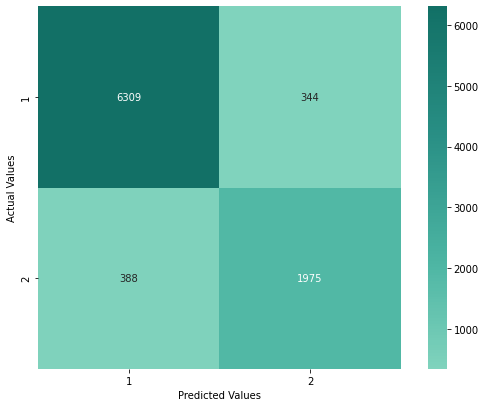

In [9]:
#Adaboost

from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators=200, random_state=42)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
cf = confusion_matrix(y_pred, y_test)
score = f1_score(y_pred, y_test, average='macro')
print(score)

#color_pallete = sns.diverging_palette(220, 20, as_cmap=True)
colors = [(0.98, 0.98, 0.98), (0.95, 0.95, 0.95), (0.85, 0.95, 0.85), (0.54, 0.85, 0.76), (0.30, 0.71, 0.64), (0.16, 0.56, 0.52), (0.07, 0.44, 0.40)]

# Create the custom colormap using the colors
turquoise_cmap = mcolors.LinearSegmentedColormap.from_list("Turquoise", colors)

x_labels = [1,2]
y_labels = x_labels
fig = sns.heatmap(cf, cmap=turquoise_cmap, center=0, square=True, annot =True, fmt='g', xticklabels=x_labels, yticklabels=y_labels)
plt.gcf().set_size_inches(10, 6.6666)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

0.785211382653213


Text(0.5, 1.0, 'Feature Importance')

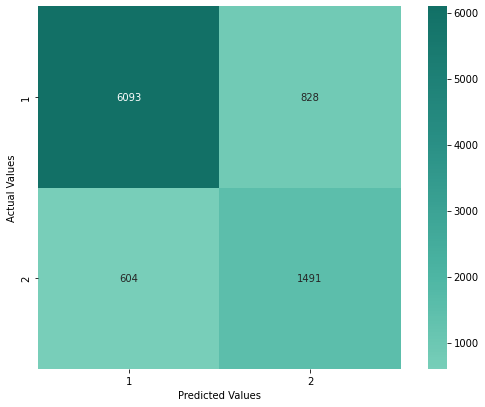

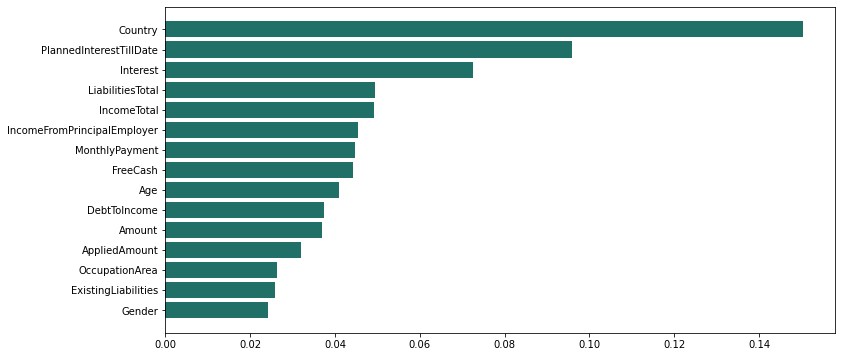

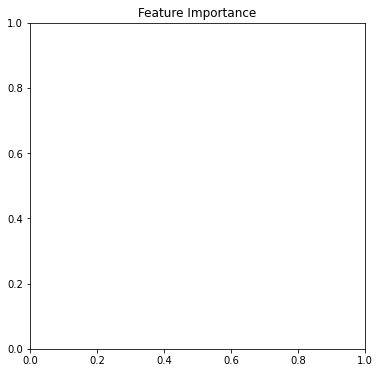

In [22]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
cf = confusion_matrix(y_pred, y_test)
score = f1_score(y_pred, y_test, average='macro')
print(score)

#color_pallete = sns.diverging_palette(220, 20, as_cmap=True)
colors = [(0.98, 0.98, 0.98), (0.95, 0.95, 0.95), (0.85, 0.95, 0.85), (0.54, 0.85, 0.76), (0.30, 0.71, 0.64), (0.16, 0.56, 0.52), (0.07, 0.44, 0.40)]

# Create the custom colormap using the colors


turquoise_cmap = mcolors.LinearSegmentedColormap.from_list("Turquoise", colors)
color_pallete = sns.diverging_palette(220, 20, as_cmap=True)
x_labels = [1,2]
y_labels = x_labels
fig = sns.heatmap(cf, cmap=turquoise_cmap, center=0, square=True, annot =True, fmt='g', xticklabels=x_labels, yticklabels=y_labels)
plt.gcf().set_size_inches(10, 6.6666)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

#bbox_inches='tight'
#plt.savefig('BondoraCM.png', bbox_inches='tight')

feature_importance = rf.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(12, 6))
plt.barh(range(15), feature_importance[sorted_idx[-15:]], align='center', color='#207068')
plt.yticks(range(15), np.array(X_test.columns)[sorted_idx[-15:]])
plt.figure(figsize=(6, 6))
plt.title('Feature Importance')

In [ ]:
from sklearn.tree import export_text

# rf = RandomForestClassifier(n_estimators=600)
# rf.fit(X_train, y_train)

best_tree_idx = rf.feature_importances_.argmax()
best_tree = rf.estimators_[best_tree_idx]

feature_names = list(df.columns)[1:]

tree_rules = export_text(best_tree, feature_names=feature_names)
tree_rules_lines = tree_rules.split('\n')

# Remove blank lines
tree_rules_lines = [line for line in tree_rules_lines if line.strip()]

# Add indentation
tree_rules_lines = ['    ' + line.strip() for line in tree_rules_lines]

# Combine multiple lines for a single condition
combined_lines = []
current_line = ''
for line in tree_rules_lines:
    if line.endswith('->'):
        current_line += line[:-2].strip()
    else:
        current_line += line.strip()
        combined_lines.append(current_line)
        current_line = ''

# Print the final output
for line in combined_lines:
    print(line)

In [38]:
# rf = RandomForestClassifier(n_estimators=800, max_features=None)
# rf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

pred_true = X_test[y_pred == 0]
pred_true = np.array(pred_true.values)
pred_false = X_test[y_pred == 1]
pred_false = np.array(pred_false.values)
X_test = np.array(X_test.values)

feature_nm = list(df.columns)[1:]

highest_freq_true = []
highest_freq_false = []
del_lst = []

for i in range(len(pred_true[0])):
    unq_t, cnts_t = np.unique(pred_true[:,i], return_counts=True)
    unq_f, cnts_f = np.unique(pred_false[:,i], return_counts=True)
    unq_m, cnts_m = np.unique(X_test[:,i], return_counts=True)
    sort_indices = np.argsort(unq_t)
    unq_t = np.sort(unq_t)
    cnts_t = cnts_t[sort_indices]
    sort_indices = np.argsort(unq_f)
    cnts_f = cnts_f[sort_indices]
    unq_f = np.sort(unq_f)
    sort_indices = np.argsort(unq_m)
    cnts_m = cnts_m[sort_indices]
    unq_m = np.sort(unq_m)
    for j in range(len(unq_m)):
        if len(unq_t) <= j:
            unq_t = np.insert(unq_t, j, unq_m[j])
            cnts_t = np.insert(cnts_t, j, 0)
        elif unq_m[j] != unq_t[j]:
            unq_t = np.insert(unq_t, j, unq_m[j])
            cnts_t = np.insert(cnts_t, j, 0)
        if len(unq_f) <= j:
            unq_f = np.insert(unq_f, j, unq_m[j])
            cnts_f = np.insert(cnts_f, j, 0)
        elif unq_m[j] != unq_f[j]:
            unq_f = np.insert(unq_f, j, unq_m[j])
            cnts_f = np.insert(cnts_f, j, 0)

    if(len(cnts_t)!=len(cnts_m) or len(cnts_f)!=len(cnts_m)):
        del_lst.append(i)
        continue
        # print(unq_t, unq_m)
        # print(len(unq_t), len(unq_m), len(cnts_t), len(cnts_m))
    cnts_t = cnts_t/cnts_m
    cnts_f = cnts_f/cnts_m

    highest_freq_true.append([list(unq_t), list(cnts_t)])
    highest_freq_false.append([list(unq_f), list(cnts_f)])
    
# pred_true = np.apply_along_axis(lambda x: np.unique(x), axis=0, arr=pred_true)
# pred_false = np.apply_along_axis(lambda x: , axis=0, arr=pred_false)
print(del_lst.reverse())
for j in del_lst:
    del feature_nm[j]


for i in range(len(highest_freq_true)):
    if len(highest_freq_false[i][0])>100:
        continue
    print(feature_nm[i], highest_freq_true[i], highest_freq_false[i])
    print(' ')



None
Age [[0, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 75], [1.0, 1.0, 1.0, 1.0, 0.8316326530612245, 0.8571428571428571, 0.8434782608695652, 0.8586572438162544, 0.8327645051194539, 0.8053435114503816, 0.8322981366459627, 0.8050314465408805, 0.7954545454545454, 0.8150470219435737, 0.7730061349693251, 0.7377049180327869, 0.7533783783783784, 0.7201365187713311, 0.7867132867132867, 0.6745098039215687, 0.7133105802047781, 0.7014388489208633, 0.7262773722627737, 0.6695278969957081, 0.6837606837606838, 0.6637554585152838, 0.7681818181818182, 0.689119170984456, 0.6432432432432432, 0.7262569832402235, 0.6462264150943396, 0.6666666666666666, 0.6046511627906976, 0.6687898089171974, 0.6971830985915493, 0.7709923664122137, 0.6521739130434783, 0.7033898305084746, 0.7070707070707071, 0.6283185840707964, 0.6694214876033058, 0.6630434

IncomeTotal
[0.7541156606162938, 0.7775132275132275, 0.28313253012048195]


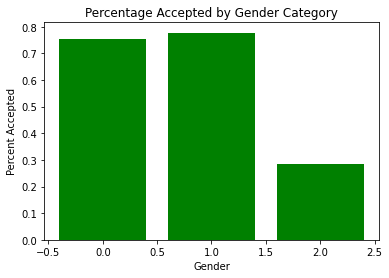

In [62]:
print(feature_nm[23])
print(highest_freq_true[1][1])

x = highest_freq_true[1][0]
y = highest_freq_true[1][1]

plt.bar(x, y, color='green')
# ax.scatter(x, y, label='Data')
# ax.plot(x, np.polyval(coefficients, x), 'r-', label='Line of Best Fit')
plt.ylabel('Percent Accepted')
plt.xlabel('Gender')
# Set the title of the plot
plt.title('Percentage Accepted by Gender Category')
# Show the plot
plt.show()

0.7565086469442027


Text(0.5, 1.0, 'Feature Importance for Gender Prediction')

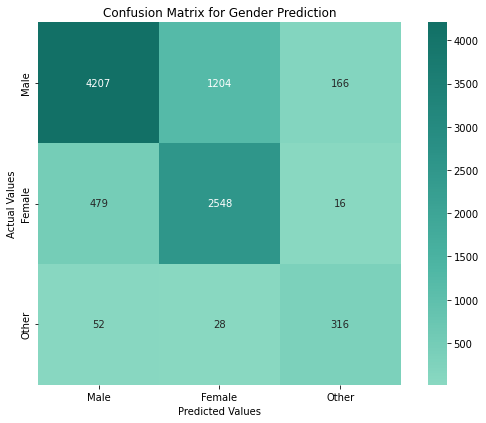

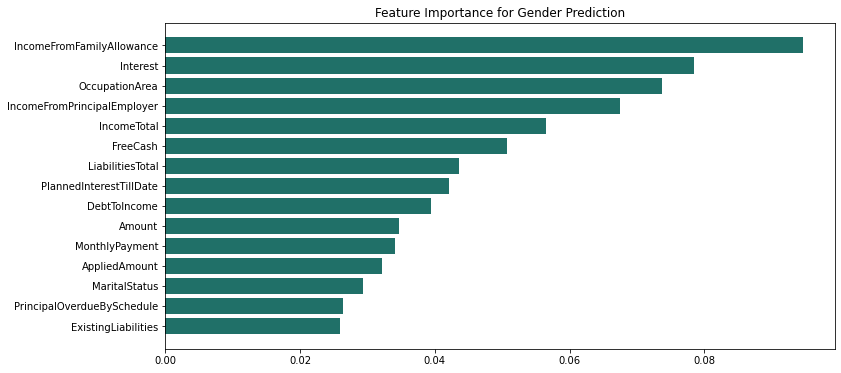

In [18]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_trainFP, y_trainFP)

y_pred = rf.predict(X_testFP)
cf = confusion_matrix(y_pred, y_testFP)
score = f1_score(y_pred, y_testFP, average='macro')
print(score)

#color_pallete = sns.diverging_palette(220, 20, as_cmap=True)
colors = [(0.98, 0.98, 0.98), (0.95, 0.95, 0.95), (0.85, 0.95, 0.85), (0.54, 0.85, 0.76), (0.30, 0.71, 0.64), (0.16, 0.56, 0.52), (0.07, 0.44, 0.40)]

# Create the custom colormap using the colors


turquoise_cmap = mcolors.LinearSegmentedColormap.from_list("Turquoise", colors)
color_pallete = sns.diverging_palette(220, 20, as_cmap=True)
x_labels = ["Male","Female","Other"]
y_labels = x_labels
fig = sns.heatmap(cf, cmap=turquoise_cmap, center=0, square=True, annot =True, fmt='g', xticklabels=x_labels, yticklabels=y_labels)
plt.gcf().set_size_inches(10, 6.6666)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix for Gender Prediction')


#bbox_inches='tight'
#plt.savefig('BondoraCM.png', bbox_inches='tight')

feature_importance = rf.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(15), feature_importance[sorted_idx[-15:]], align='center', color='#207068')
plt.yticks(range(15), np.array(X_testFP.columns)[sorted_idx[-15:]])
plt.title('Feature Importance for Gender Prediction')

0.6720334320238148


Text(0.5, 1.0, 'Feature Importance')

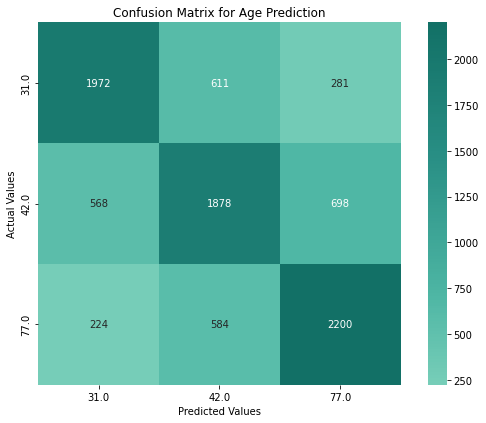

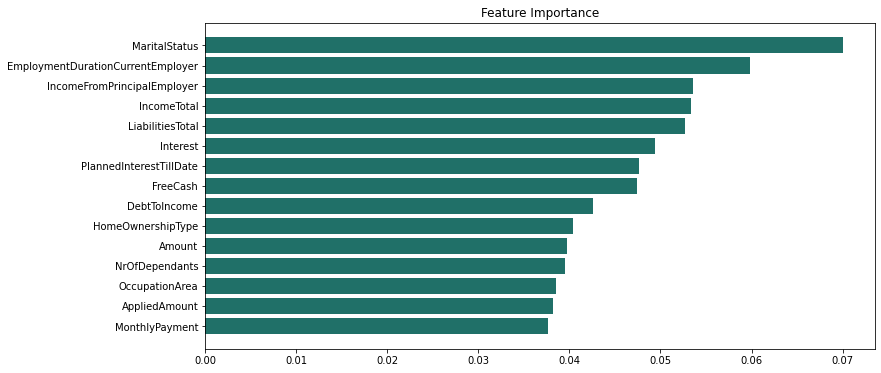

In [25]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_trainAP, y_trainAP)

y_pred = rf.predict(X_testAP)
cf = confusion_matrix(y_pred, y_testAP)
score = f1_score(y_pred, y_testAP, average='macro')
print(score)

#color_pallete = sns.diverging_palette(220, 20, as_cmap=True)
colors = [(0.98, 0.98, 0.98), (0.95, 0.95, 0.95), (0.85, 0.95, 0.85), (0.54, 0.85, 0.76), (0.30, 0.71, 0.64), (0.16, 0.56, 0.52), (0.07, 0.44, 0.40)]

# Create the custom colormap using the colors
turquoise_cmap = mcolors.LinearSegmentedColormap.from_list("Turquoise", colors)
color_pallete = sns.diverging_palette(220, 20, as_cmap=True)
x_labels = np.ceil(bin_edges[1:4])
y_labels = x_labels
fig = sns.heatmap(cf, cmap=turquoise_cmap, center=0, square=True, annot =True, fmt='g', xticklabels=x_labels, yticklabels=y_labels)
plt.gcf().set_size_inches(10, 6.6666)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix for Age Prediction')

#bbox_inches='tight'
#plt.savefig('BondoraCM.png', bbox_inches='tight')

feature_importance = rf.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(15), feature_importance[sorted_idx[-15:]], align='center', color='#207068')
plt.yticks(range(15), np.array(X_testAP.columns)[sorted_idx[-15:]])
plt.title('Feature Importance')